In [1]:
import os
import vector
import mplhep
import numpy as np
import pandas as pd
import awkward as ak
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl

    
import mplhep
mplhep.style.use("CMS")

Reading our original data files

In [2]:
qq_test = ak.from_parquet(r"qq_train.parquet")
z_test = ak.from_parquet(r"z_train.parquet")
zh_test = ak.from_parquet(r"zh_train.parquet")

In [3]:
qq_test.reco_cand_p4s

<Array [[{x: -14.4, y: -1.72, ...}, ...], ...] type='3799829 * var * Moment...'>

In [4]:
zh_test.reco_cand_p4s

<Array [[{x: 1.96, y: 21.5, ...}, ...], ...] type='2087907 * var * Momentum...'>

In [4]:
qq_test.reco_cand_p4s

<Array [[{x: -14.4, y: -1.72, ...}, ...], ...] type='3799829 * var * Moment...'>

Creating the four vectors and changing to angular coordinates

In [5]:
# Create 4-vectors from the information in the .parquet file test and access information such as energy or pT:

def to_p4(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )
def my_to_ptphietaenergy(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "pt": p4_obj.pt,
                "phi": p4_obj.phi,
                "eta": p4_obj.rapidity,
                "E": p4_obj.E
            }
        )
    )

def to_bh(test, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(test)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

# ZH
zh_gen_tau_p4s = to_p4(zh_test.gen_jet_tau_p4s)
zh_reco_cand_p4s = to_p4(zh_test.reco_cand_p4s)
zh_reco_jet_p4s = to_p4(zh_test.reco_jet_p4s)

zh_test["4momentum"] = my_to_ptphietaenergy(zh_reco_cand_p4s)
# Z
z_gen_tau_p4s = to_p4(z_test.gen_jet_tau_p4s)
z_reco_cand_p4s = to_p4(z_test.reco_cand_p4s)
z_reco_jet_p4s = to_p4(z_test.reco_jet_p4s)
z_gen_tau_pt = z_gen_tau_p4s.pt
z_test["4momentum"] = my_to_ptphietaenergy(z_reco_cand_p4s)
#qq
qq_test_reco_cand_p4s = to_p4(qq_test["reco_cand_p4s"])
qq_test_reco_jet_p4s = to_p4(qq_test["reco_jet_p4s"])
qq_test["4momentum"] = my_to_ptphietaenergy(qq_test_reco_jet_p4s)

In [7]:
print(zh_reco_cand_p4s)

[[{x: 1.96, y: 21.5, z: 39.8, tau: 0.14}, ..., {x: 0.32, y: 2.51, ...}], ...]


In [6]:
qq_test.reco_cand_pdg

<Array [[211, 211, 22, ..., 211, 11, 211], ...] type='3799829 * var * int64'>

In [7]:
ak.to_parquet(qq_test.reco_cand_pdg, "my_pid_qq.parquet" )
ak.to_parquet(zh_test.reco_cand_pdg, "my_pid_zh.parquet" )
ak.to_parquet(z_test.reco_cand_pdg, "my_pid_z.parquet" )

  created_by: parquet-cpp-arrow version 18.0.0-SNAPSHOT
  num_columns: 1
  num_rows: 1841526
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

Renaming columns for root file for particle transformer

In [27]:
zh_test["part_energy"] = zh_reco_cand_p4s.E
zh_test["part_px"] = zh_reco_cand_p4s.x
zh_test["part_py"] = zh_reco_cand_p4s.y
zh_test["part_phi"] = zh_reco_cand_p4s.phi
zh_test["part_eta"] = zh_reco_cand_p4s.eta
zh_test["jet_pt"] = zh_reco_jet_p4s.pt
zh_test["jet_energy"] = zh_reco_cand_p4s.E
zh_test["jet_eta"] = zh_reco_jet_p4s.eta
zh_test["jet_phi"] = zh_reco_jet_p4s.phi
zh_test["part_deta"] = zh_reco_cand_p4s
zh_test["part_deta"] = zh_reco_cand_p4s

z_test["part_energy"] = z_reco_cand_p4s.E
z_test["part_px"] = z_reco_cand_p4s.x
z_test["part_py"] = z_reco_cand_p4s.y
z_test["jet_pt"] = z_reco_jet_p4s.pt
z_test["jet_energy"] = z_reco_jet_p4s.E
z_test["jet_eta"] = z_reco_jet_p4s.eta
z_test["jet_phi"] = z_reco_jet_p4s.phi
z_test["part_phi"] = z_reco_cand_p4s.phi
z_test["part_eta"] = z_reco_cand_p4s.eta

qq_test["part_energy"] = qq_test_reco_cand_p4s.E
qq_test["part_px"] = qq_test_reco_cand_p4s.x
qq_test["part_py"] = qq_test_reco_cand_p4s.y
qq_test["jet_pt"] = qq_test_reco_jet_p4s.pt
qq_test["jet_energy"] = qq_test_reco_jet_p4s.E
qq_test["jet_eta"] = qq_test_reco_jet_p4s.eta
qq_test["jet_phi"] = qq_test_reco_jet_p4s.phi
qq_test["part_phi"] = qq_test_reco_cand_p4s.phi
qq_test["part_eta"] = qq_test_reco_cand_p4s.eta

In [28]:
qq_test = qq_test[["part_energy","part_px","part_py","jet_pt","jet_energy","jet_eta","jet_phi","part_phi","part_eta"]]
zh_test = zh_test[["part_energy","part_px","part_py","jet_pt","jet_energy","jet_eta","jet_phi","part_phi","part_eta"]]
z_test = z_test[["part_energy","part_px","part_py","jet_pt","jet_energy","jet_eta","jet_phi","part_phi","part_eta"]]

In [29]:
import gc
gc.collect()

1618

In [30]:
zh_test["part_energy"] = ak.fill_none(ak.pad_none(zh_test["part_energy"], target=100,clip=True), 0)
zh_test["part_px"] = ak.fill_none(ak.pad_none(zh_test["part_px"], target=100,clip=True), 0)
zh_test["part_py"] = ak.fill_none(ak.pad_none(zh_test["part_py"], target=100,clip=True), 0)
zh_test["part_eta"] = ak.fill_none(ak.pad_none(zh_test["part_eta"], target=100,clip=True), 0)
zh_test["part_phi"] = ak.fill_none(ak.pad_none(zh_test["part_phi"], target=100,clip=True), 0)

z_test["part_energy"] = ak.fill_none(ak.pad_none(z_test["part_energy"], target=100,clip=True), 0)
z_test["part_px"] = ak.fill_none(ak.pad_none(z_test["part_px"], target=100,clip=True), 0)
z_test["part_py"] = ak.fill_none(ak.pad_none(z_test["part_py"], target=100,clip=True), 0)
z_test["part_eta"] = ak.fill_none(ak.pad_none(z_test["part_eta"], target=100,clip=True), 0)
z_test["part_phi"] = ak.fill_none(ak.pad_none(z_test["part_phi"], target=100,clip=True), 0)


qq_test["part_energy"] = ak.fill_none(ak.pad_none(qq_test["part_energy"], target=100,clip=True), 0)
qq_test["part_px"] = ak.fill_none(ak.pad_none(qq_test["part_px"], target=100,clip=True), 0)
qq_test["part_py"] = ak.fill_none(ak.pad_none(qq_test["part_py"], target=100,clip=True), 0)
qq_test["part_eta"] = ak.fill_none(ak.pad_none(qq_test["part_eta"], target=100,clip=True), 0)
qq_test["part_phi"] = ak.fill_none(ak.pad_none(qq_test["part_phi"], target=100,clip=True), 0)



In [31]:
zh_test["label"] = np.ones(len(zh_test["jet_pt"]))
z_test["label"] = np.ones(len(z_test["jet_pt"]))
qq_test["label"] = np.zeros(len(qq_test["jet_pt"]))

In [32]:
my_data = zh_test[["part_energy","part_px","part_py","jet_pt","jet_energy","label", "jet_eta", "jet_phi", "part_eta", "part_phi"]]
my_data_z = z_test[["part_energy","part_px","part_py","jet_pt","jet_energy","label", "jet_eta", "jet_phi", "part_eta", "part_phi"]]
my_data2 = qq_test[["part_energy","part_px","part_py","jet_pt","jet_energy","label", "jet_eta", "jet_phi", "part_eta", "part_phi"]]

In [33]:
my_data

<Array [{part_energy: [...], ...}, ..., {...}] type='1000 * {part_energy: 1...'>

In [34]:
my_data3 = ak.concatenate([my_data,my_data2, my_data_z], axis=0)

In [35]:
my_data3

<Array [{part_energy: [...], ...}, ..., {...}] type='3000 * union[{part_ene...'>

In [36]:
import gc
gc.collect()

142

In [37]:
import uproot

In [38]:
my_data3

<Array [{part_energy: [...], ...}, ..., {...}] type='3000 * union[{part_ene...'>

root file

In [40]:
chunk_size = 1000
total_elements = len(my_data_z)
with uproot.recreate("my_data_sample7.root") as root_file:
    root_file["tree"] = {"part_energy": my_data_z["part_energy"], "part_px" : my_data_z["part_px"],"part_py" : my_data_z["part_py"], "jet_pt": my_data_z["jet_pt"], "jet_energy":my_data_z["jet_energy"], "label":my_data_z["label"], "jet_eta":my_data_z["jet_phi"], "jet_phi":my_data_z["jet_phi"], "part_eta":my_data_z["part_eta"], "part_phi":my_data_z["part_phi"]}  # Write the first chunk (initialize the tree)

rest is random visualizations and unimportant checks

In [12]:
my_data_padded = ak.pad_none(my_data, target=100, clip=True, axis=1)

AxisError: axis=1 exceeds the depth of this array (1)

This error occurred while calling

    ak.pad_none(
        <Array [{part_energy: [...], ...}, ...] type='1068606 * {part_energ...'>
        target = 100
        clip = True
        axis = 1
    )

In [11]:
my_data_padded

<Array [{part_energy: [...], ...}, ..., {...}] type='100 * ?{part_energy: v...'>

In [11]:
ak.to_parquet(my_data, "my_data.parquet")

  created_by: parquet-cpp-arrow version 18.0.0-SNAPSHOT
  num_columns: 5
  num_rows: 1068606
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [7]:
zh_test["part_energy"]

<Array [[44.3, 33.3, ..., 0.993, 0.184], ...] type='1068606 * var * float64'>

In [4]:
ak.to_parquet(qq_test, "my_qqcand_test.parquet")
ak.to_parquet(z_test, "my_zcand_test.parquet")
ak.to_parquet(zh_test, "my_zhcand_test.parquet")

  created_by: parquet-cpp-arrow version 18.0.0-SNAPSHOT
  num_columns: 27
  num_rows: 1068606
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [ ]:
z_reco_cand_p4s.phi

<Array [[2.36], ..., [-1.07, -1.08, ..., -1.21]] type='1841526 * var * float64'>

In [ ]:
zh_reco_cand_p4s_phieta.phi

In [ ]:
#zh
phis = zh_reco_cand_p4s_phieta.phi
etas = zh_reco_cand_p4s_phieta.eta
rho = zh_reco_cand_p4s_phieta.rho
dxdy = zh_data.reco_cand_dxy
#qq
phis2 = qq_data_reco_cand_p4s_phieta.phi
etas2 = qq_data_reco_cand_p4s_phieta.eta
rho2 = qq_data_reco_cand_p4s_phieta.rho
dxdy2 = qq_data.reco_cand_dxy
#z
phis3 = z_reco_cand_p4s_phieta.phi
etas3 = z_reco_cand_p4s_phieta.eta
rho3 = z_reco_cand_p4s_phieta.rho
dxdy3 = z_data.reco_cand_dxy

In [ ]:
phis = ak.to_numpy(ak.flatten(phis))
etas=ak.to_numpy(ak.flatten(etas))
rhos=ak.to_numpy(ak.flatten(rho))
dxdy = ak.to_numpy(ak.flatten(dxdy))
##qq
phis2 = ak.to_numpy(ak.flatten(phis2))
etas2=ak.to_numpy(ak.flatten(etas2))
rhos2=ak.to_numpy(ak.flatten(rho2))
dxdy2 = ak.to_numpy(ak.flatten(dxdy2))

#z
phis3 = ak.to_numpy(ak.flatten(phis3))
etas3=ak.to_numpy(ak.flatten(etas3))
rhos3=ak.to_numpy(ak.flatten(rho3))
dxdy3 = ak.to_numpy(ak.flatten(dxdy3))


In [ ]:
myphis = pd.Series(phis)
myetas = pd.Series(etas)
myrho = pd.Series(rhos)
dxdy = pd.Series(dxdy)
#
myphis2 = pd.Series(phis2)
myetas2 = pd.Series(etas2)
myrho2 = pd.Series(rhos2)
dxdy2 = pd.Series(dxdy2)

#
myphis3 = pd.Series(phis3)
myetas3 = pd.Series(etas3)
myrho3 = pd.Series(rhos3)
dxdy3 = pd.Series(dxdy3)

In [ ]:
myphis=myphis.sample(7000, random_state=42)
myetas = myetas.sample(7000, random_state=42)
myrho = myrho.sample(7000, random_state=42)
mydxdy = dxdy.sample(7000,random_state=42)
#
myphis2=myphis2.sample(7000, random_state=42)
myetas2 = myetas2.sample(7000, random_state=42)
myrho2 = myrho2.sample(7000, random_state=42)
mydxdy2 = dxdy2.sample(7000,random_state=42)

myphis3=myphis3.sample(7000, random_state=42)
myetas3 = myetas3.sample(7000, random_state=42)
myrho3 = myrho3.sample(7000, random_state=42)
mydxdy3 = dxdy3.sample(7000,random_state=42)

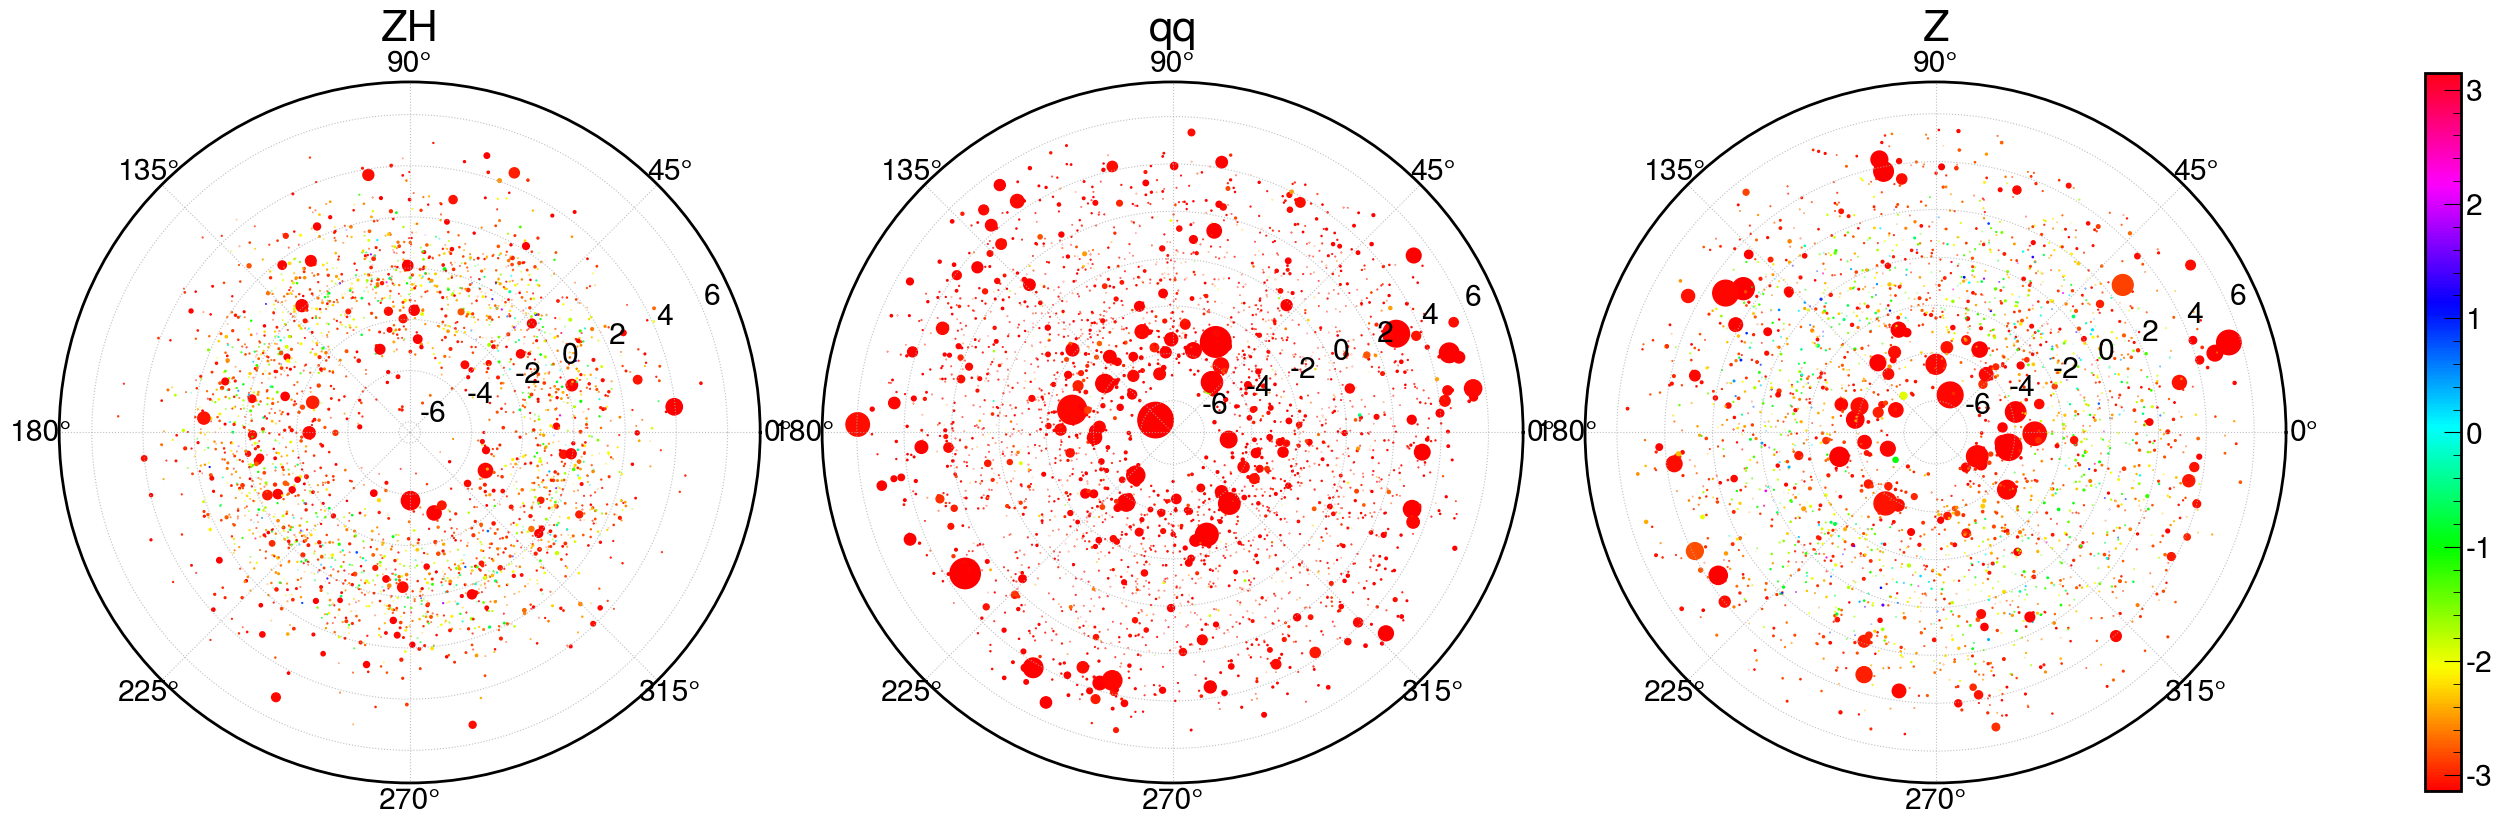

In [ ]:


radius   = 2 * myetas
angles   = (180) * myphis
colors = myrho
radius2   = 2 * myetas2
angles2   = (180) * myphis2
colors2 = myrho2
radius3   = 2 * myetas3
angles3   = (180) * myphis3
colors3 = myrho3

fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection="polar"))
fig.set_size_inches(29,9)
fig.tight_layout()
axs[0].scatter(angles, radius, c=colors, s=mydxdy*10,alpha=1,cmap=plt.cm.hsv)
axs[0].set_title("ZH")
axs[1].scatter(angles2, radius2, c=colors2, s=mydxdy2*10,alpha=1,cmap=plt.cm.hsv)
axs[1].set_title("qq")
axs[2].scatter(angles3, radius3, c=colors3, s=mydxdy3*10,alpha=1,cmap=plt.cm.hsv)
axs[2].set_title("Z")

"""a = .scatter(angles, radius, c=colors, s=mydxdy*15,alpha=1,cmap=plt.cm.hsv, polar = True)"""

fig.tight_layout()
from matplotlib.cm import ScalarMappable
cmap = plt.get_cmap("hsv")
norm = plt.Normalize(myphis.min(), myphis.max())
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs[:])
cbar.norm
plt.show()
fig.savefig("visualization-radar-buble-plot.png")

In [ ]:
ak.to_parquet(zh_reco_cand_p4s_phieta, "my_zhcand.parquet")
ak.to_parquet(qq_data_reco_cand_p4s_phieta, "my_qqcand.parquet")
ak.to_parquet(z_reco_cand_p4s_phieta, "my_zcand.parquet")

  created_by: parquet-cpp-arrow version 18.0.0-SNAPSHOT
  num_columns: 4
  num_rows: 1841526
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 0

In [ ]:
zh_reco_cand_p4s = zh_reco_cand_p4s.to_ptphietaenergy

In [ ]:
zh_reco_cand_p4s

<bound method Vector.to_ptphietaenergy of <MomentumArray4D [[{x: 1.96, y: 21.5, ...}, ...], ...] type='2087907 * var ...'>>

In [ ]:
a = np.array(zh_reco_cand_p4s)

In [ ]:
zh_reco_cand_p4s

<bound method Vector.to_ptphietaenergy of <MomentumArray4D [[{x: 1.96, y: 21.5, ...}, ...], ...] type='2087907 * var ...'>>

In [ ]:
z_reco_jet_p4s

<MomentumArray4D [{x: -10.8, y: 10.8, z: ..., ...}, ...] type='1841526 * Mo...'>

### $\Delta \eta$ and $\Delta \phi$

In [ ]:
z_data.gen_jet_p4s[100]

<Record {x: -13, y: -3.1, z: -26, tau: ..., ...} type='Momentum4D[x: float6...'>

In [ ]:
z_delta_phi

<Array [[0], ..., [0.00336, 0.0088, ..., 0.137]] type='1841526 * var * float64'>

Text(0.5, 1.0, 'Fraction of particles $|\\Delta \\eta|<0.8$ = 0.99')

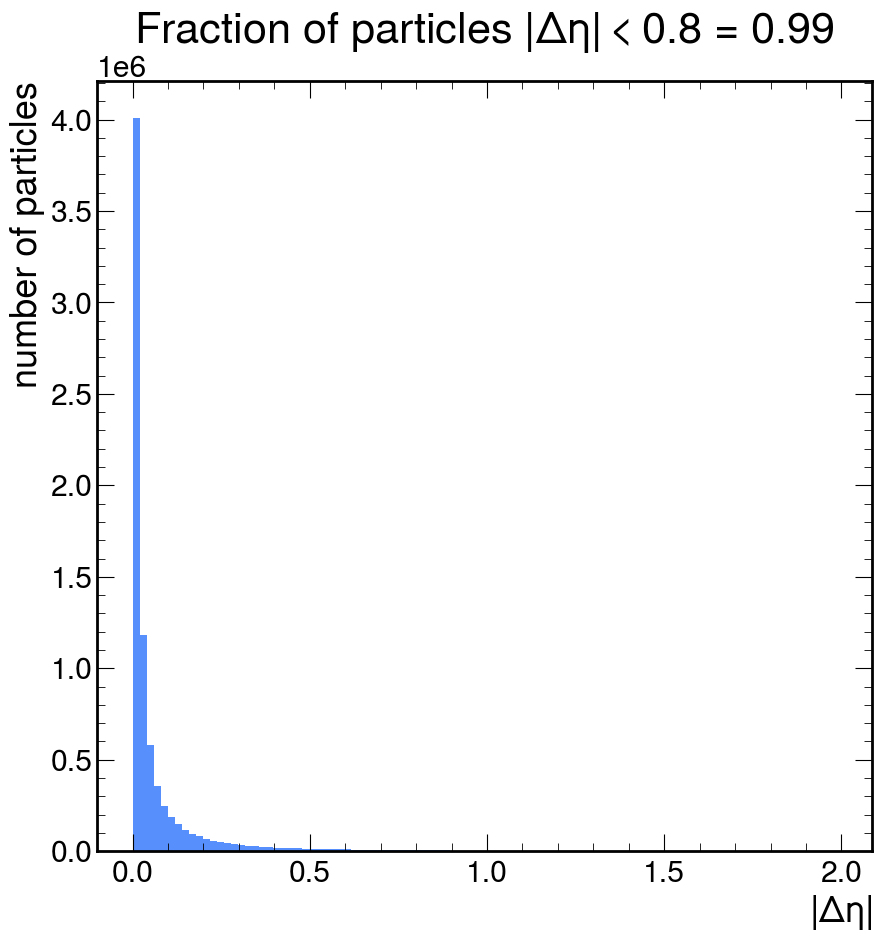

In [ ]:
plt.hist(np.abs(ak.flatten(z_delta_eta)), bins=100);
plt.xlabel("$|\Delta \eta|$")
plt.ylabel("number of particles")
plt.title("Fraction of particles $|\Delta \eta|<0.8$ = {:.2f}".format(np.sum(np.abs(ak.flatten(z_delta_eta))<0.8) / ak.count(z_delta_eta)))

Text(0.5, 1.0, 'Fraction of particles $|\\Delta \\Phi|<0.8$ = 0.98')

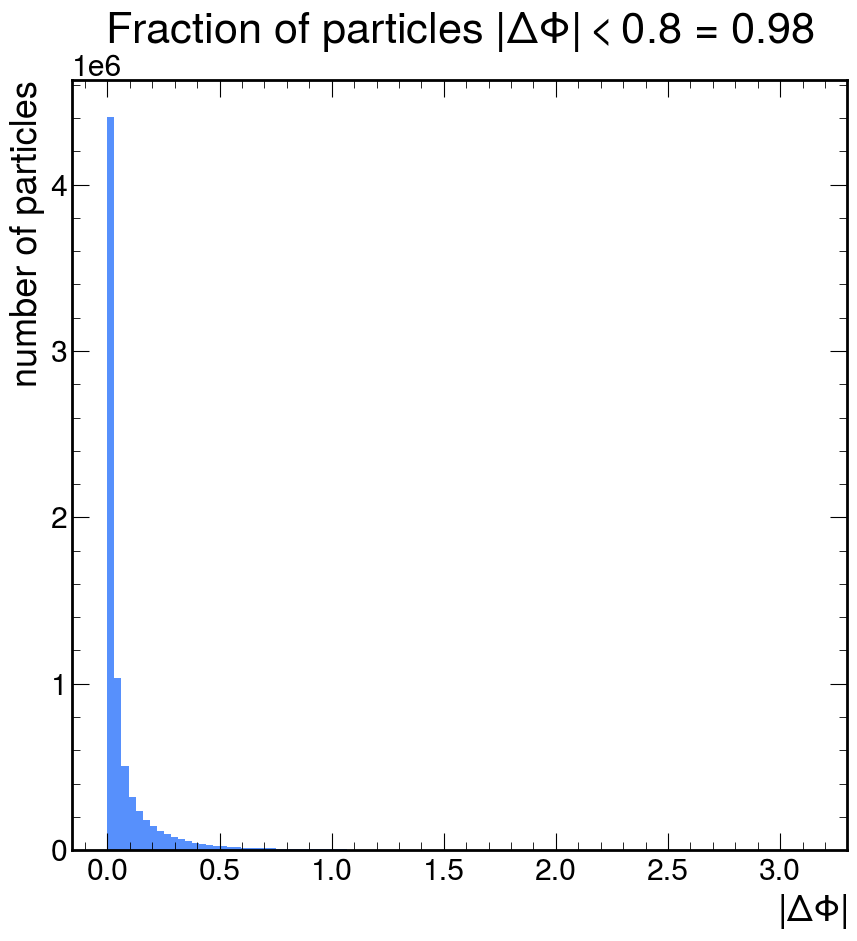

In [ ]:
plt.hist(np.abs(ak.flatten(z_delta_phi)), bins=100);
plt.xlabel("$|\Delta \Phi|$")
plt.ylabel("number of particles")
plt.title("Fraction of particles $|\Delta \Phi|<0.8$ = {:.2f}".format(np.sum(np.abs(ak.flatten(z_delta_phi))<0.8) / ak.count(z_delta_phi)))

## Number of particles per jet

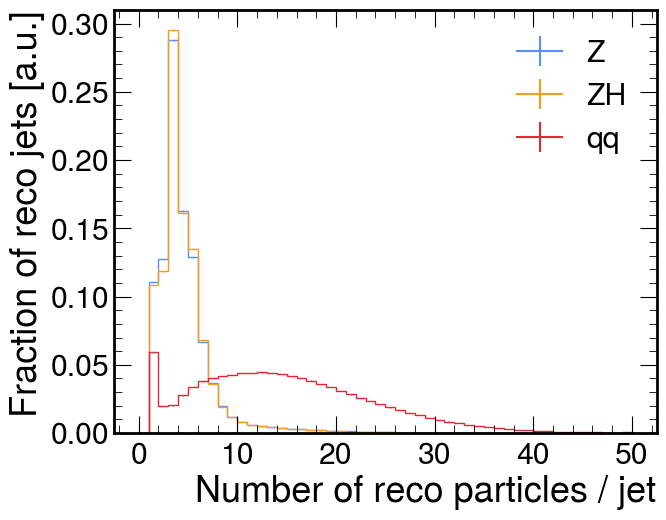

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,50,51)

# Z plot
mplhep.histplot(to_bh(ak.num(z_data["reco_cand_p4s"]), bins=bins), 
                histtype="step", 
                lw=1, 
                flow="sum", 
                label="Z", 
                density=True)
# ZH plot
mplhep.histplot(to_bh(ak.num(zh_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)
# qq plot
mplhep.histplot(to_bh(ak.num(qq_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best")
#plt.yscale("log")

plt.xlabel("Number of reco particles / jet")
plt.ylabel("Fraction of reco jets [a.u.]")

#plt.tight_layout()

plt.savefig("number_reco_particles.pdf", bbox_inches='tight')

## Reconstructed jet $p_T$

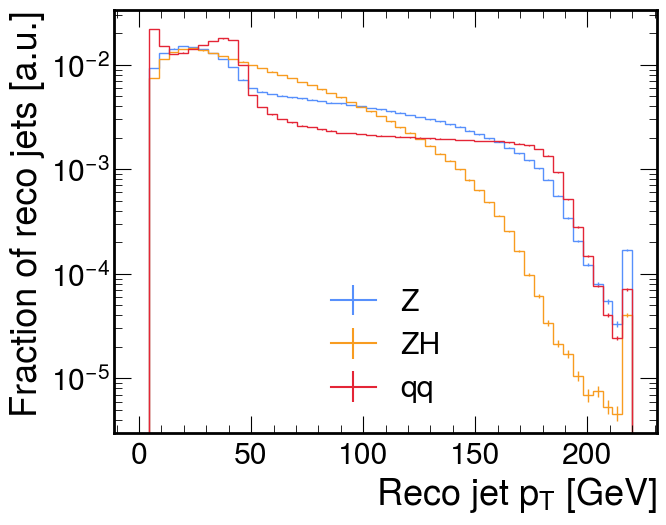

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="ZH",
                density=True)
# # qq plot
mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins),
                 histtype="step",
                 lw=1,
                 flow="sum",
                 label="qq",
                 density=True)

plt.legend(loc="best")
plt.yscale("log")

plt.xlabel("Reco jet $p_T$ [GeV]")
plt.ylabel("Fraction of reco jets [a.u.]");

plt.savefig("reco_jet_pt.pdf", bbox_inches='tight')

In [ ]:
z_p4s=pd.DataFrame(to_p4(z_data["reco_jet_p4s"]).pt)
z_p4s.to_csv("z_p4s.csv")
zh_p4s = pd.DataFrame(to_p4(zh_data["reco_jet_p4s"]).pt)
zh_p4s.to_csv("zh_p4s.csv")
q_p4s = pd.DataFrame(to_p4(qq_data["reco_jet_p4s"]).pt)
q_p4s.to_csv("qq_p4s.csv")

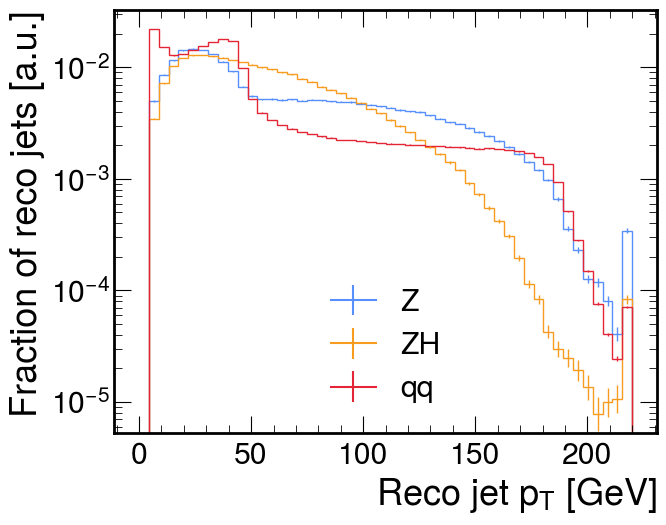

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

z_data_mask = z_data.gen_jet_tau_decaymode == 10
zh_data_mask = zh_data.gen_jet_tau_decaymode == 10

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt[z_data_mask], bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt[zh_data_mask], bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="ZH",
                density=True)
 #qq plot
mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins),
                 histtype="step",
                 lw=1,
                 flow="sum",
                 label="qq",
                 density=True)

plt.legend(loc="best")
plt.yscale("log")

plt.xlabel("Reco jet $p_T$ [GeV]")
plt.ylabel("Fraction of reco jets [a.u.]");

plt.savefig("reco_jet_pt_dm10.pdf", bbox_inches='tight')

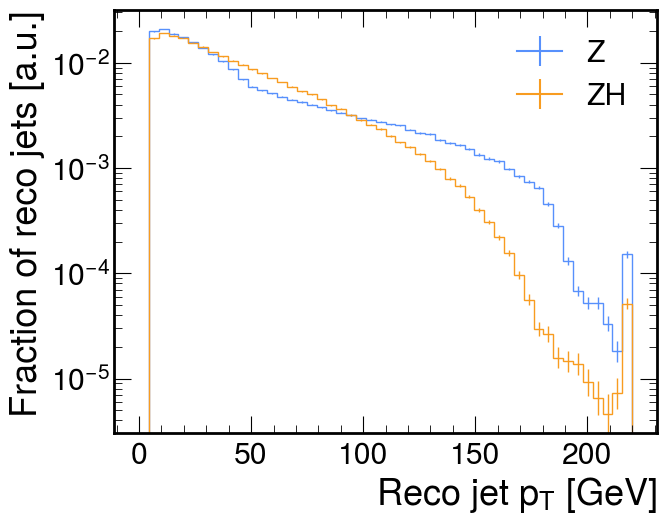

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

z_data_mask = z_data.gen_jet_tau_decaymode == 0
zh_data_mask = zh_data.gen_jet_tau_decaymode == 0

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt[z_data_mask], bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt[zh_data_mask], bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="ZH",
                density=True)
# # qq plot
# mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins),
#                 histtype="step",
#                 lw=1,
#                 flow="sum",
#                 label="qq",
#                 density=True)

plt.legend(loc="best")
plt.yscale("log")

plt.xlabel("Reco jet $p_T$ [GeV]")
plt.ylabel("Fraction of reco jets [a.u.]");

plt.savefig("reco_jet_pt_dm0.pdf", bbox_inches='tight')

### Generated jet $p_T$

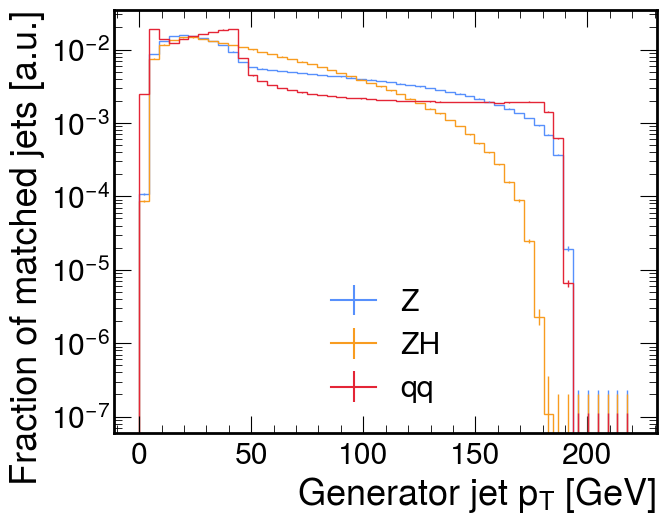

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

mplhep.histplot(to_bh(to_p4(qq_data["gen_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("Generator jet $p_T$ [GeV]")
plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("gen_jet_pt.pdf", bbox_inches='tight')

### Tau lepton visible $p_T$

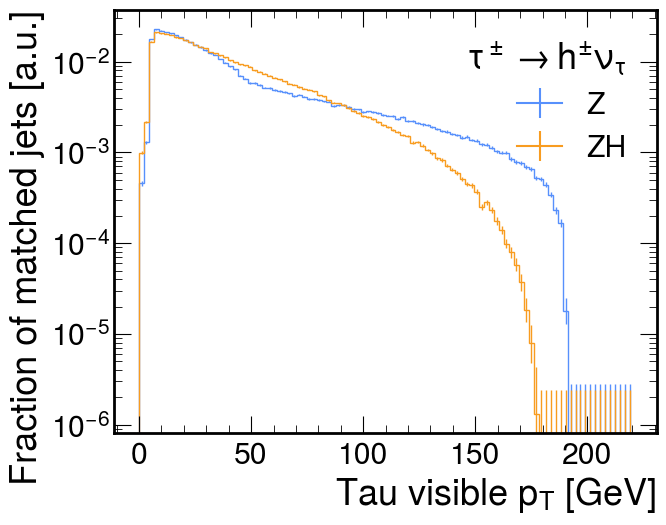

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,101)


z_data_mask = z_data.gen_jet_tau_decaymode == 0
zh_data_mask = zh_data.gen_jet_tau_decaymode == 0
# Z plot
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_tau_p4s"]).pt[z_data_mask], bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_tau_p4s"]).pt[zh_data_mask], bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

legend_obj = plt.legend(title=r"$\tau^\pm \rightarrow h^{\pm}\nu_\tau$", loc="upper right")
legend_obj._legend_box.align = "right"
plt.yscale("log")
plt.xlabel("Tau visible $p_T$ [GeV]")
plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("gen_tau_visible_pt_dm0.pdf", bbox_inches='tight')

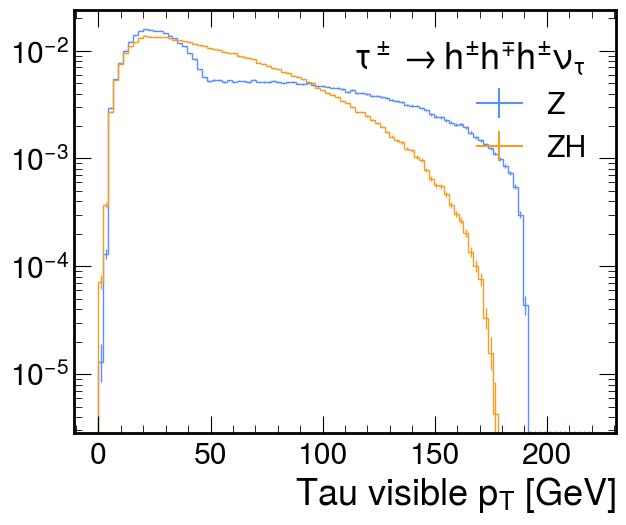

In [ ]:
fig = plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,101)


z_data_mask = z_data.gen_jet_tau_decaymode == 10
zh_data_mask = zh_data.gen_jet_tau_decaymode == 10
# Z plot
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_tau_p4s"]).pt[z_data_mask], bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_tau_p4s"]).pt[zh_data_mask], bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

legend_obj = plt.legend(title=r"$\tau^\pm \rightarrow h^{\pm}h^{\mp}h^{\pm}\nu_\tau$", loc="upper right")
legend_obj._legend_box.align = "right"
plt.yscale("log")
plt.xlabel("Tau visible $p_T$ [GeV]")
# plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("gen_tau_visible_pt_dm10.pdf", bbox_inches='tight')

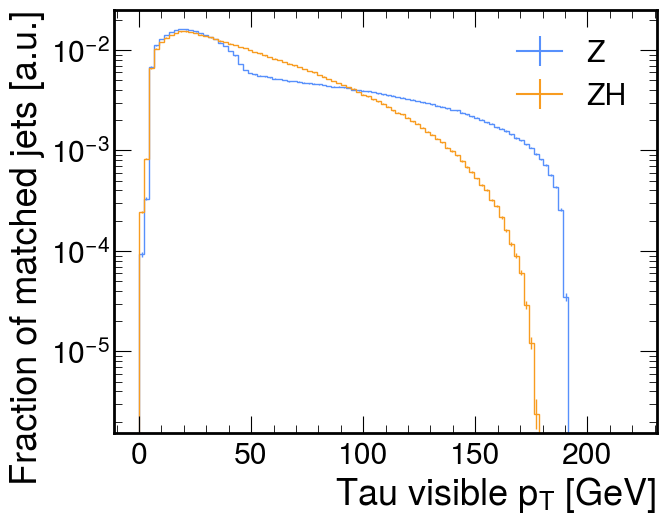

In [ ]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,101)

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

plt.legend(loc="upper right")
plt.yscale("log")
plt.xlabel("Tau visible $p_T$ [GeV]")
plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("gen_tau_visible_pt.pdf", bbox_inches='tight')

### Reco-jet to gen-jet ratio

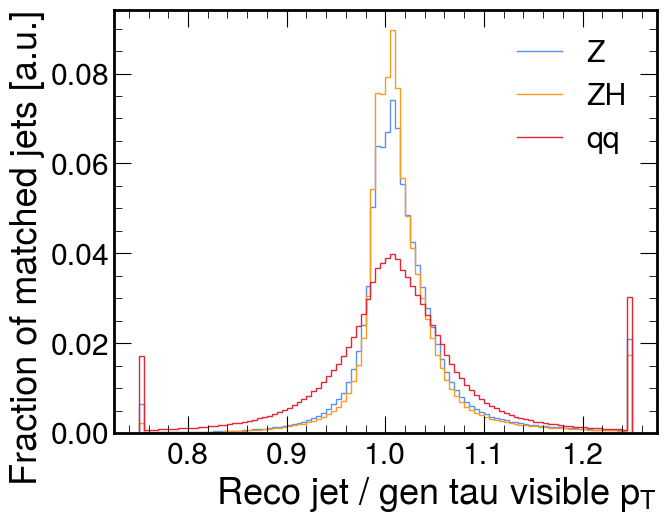

In [ ]:
bins = np.linspace(0.75,1.25,101)
plt.figure(figsize=(7,5.5))

# Normalize pT
# Z
z_pt = (to_bh(to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_p4s"]).pt, bins=bins) /
        len(to_p4(z_data["reco_jet_p4s"]).pt))
# ZH
zh_pt = (to_bh(to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_p4s"]).pt, bins=bins) /
         len(to_p4(zh_data["reco_jet_p4s"]).pt))

qq_pt = (to_bh(to_p4(qq_data["reco_jet_p4s"]).pt / to_p4(qq_data["gen_jet_p4s"]).pt, bins=bins) /
         len(to_p4(qq_data["reco_jet_p4s"]).pt))

# Z plot
mplhep.histplot(z_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="Z",
    density=False)

# ZH plot
mplhep.histplot(zh_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="ZH",
    density=False)

# ZH plot
mplhep.histplot(qq_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="qq",
    density=False)

plt.legend(loc="best")
#plt.yscale("log")
plt.xlabel("Reco jet / gen tau visible $p_T$")
plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("reco_gen_jet_pt.pdf", bbox_inches='tight')

### Tau visible pt and reconstructed jet $p_T$ ratio
Should be around 1

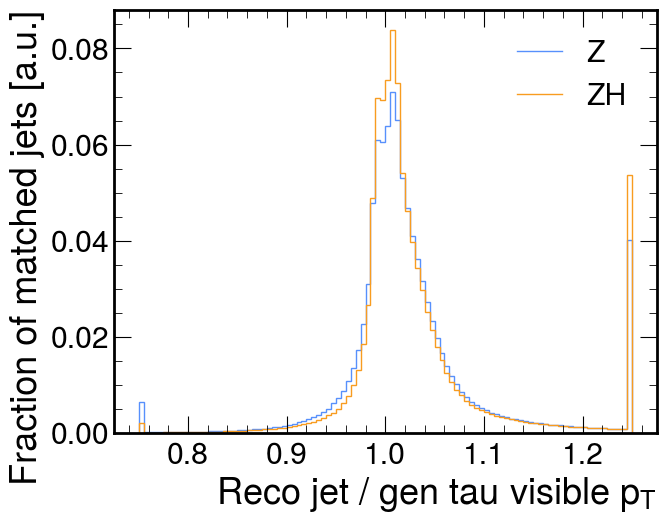

In [ ]:
bins = np.linspace(0.75,1.25,101)
plt.figure(figsize=(7,5.5))

# Normalize pT
# Z
z_pt = (to_bh(to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_tau_p4s"]).pt, bins=bins) /
        len(to_p4(z_data["reco_jet_p4s"]).pt))
# ZH
zh_pt = (to_bh(to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_tau_p4s"]).pt, bins=bins) /
         len(to_p4(zh_data["reco_jet_p4s"]).pt))

# Z plot
mplhep.histplot(z_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="Z",
    density=False)

# ZH plot
mplhep.histplot(zh_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="ZH",
    density=False)

plt.legend(loc="best")
#plt.yscale("log")
plt.xlabel("Reco jet / gen tau visible $p_T$")
plt.ylabel("Fraction of matched jets [a.u.]");

plt.savefig("reco_gen_tau_pt.pdf", bbox_inches='tight')

## Decay mode Mapping

<table>
<tr>
<th>One Prong</th>
<th>Two Prong</th>
<th>Three Prong</th>
<th>Other</th>
</tr>
<tr>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 0  | OneProng0PiZero   | $\text{h}^\pm$       |
| 1  | OneProng1PiZero   | $\text{h}^\pm + \pi^0$|
| 2  | OneProng2PiZero   | $\text{h}^\pm + 2\pi^0$|
| 3  | OneProng3PiZero   | $\text{h}^\pm + 3\pi^0$|
| 4  | OneProngNPiZero   | $\text{h}^\pm + N\pi^0$|

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 5  | TwoProng0PiZero   | $\text{2h}$          |
| 6  | TwoProng1PiZero   | $\text{2h} + \pi^0$  |
| 7  | TwoProng2PiZero   | $\text{2h} + 2\pi^0$ |
| 8  | TwoProng3PiZero   | $\text{2h} + 3\pi^0$ |
| 9  | TwoProngNPiZero   | $\text{2h} + N\pi^0$ |

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 10 | ThreeProng0PiZero | $\text{3h}^\pm$      |
| 11 | ThreeProng1PiZero | $\text{3h}^\pm + \pi^0$|
| 12 | ThreeProng2PiZero | $\text{3h}^\pm + 2\pi^0$|
| 13 | ThreeProng3PiZero | $\text{3h}^\pm + 3\pi^0$|
| 14 | ThreeProngNPiZero | $\text{3h}^\pm + N\pi^0$|

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 15 | RareDecayMode     | Other                |

</td>
</tr>
</table>


In [ ]:
def DM_percentages(data):
    """
    Calculate the percentages of decay modes in the given data.
    """
    uniques, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    percentages = np.round((counts / total_count) * 100, 2)
    return dict(zip(uniques, percentages))

z_data_percentages = DM_percentages(z_data["gen_jet_tau_decaymode"])
zh_data_percentages = DM_percentages(zh_data["gen_jet_tau_decaymode"])

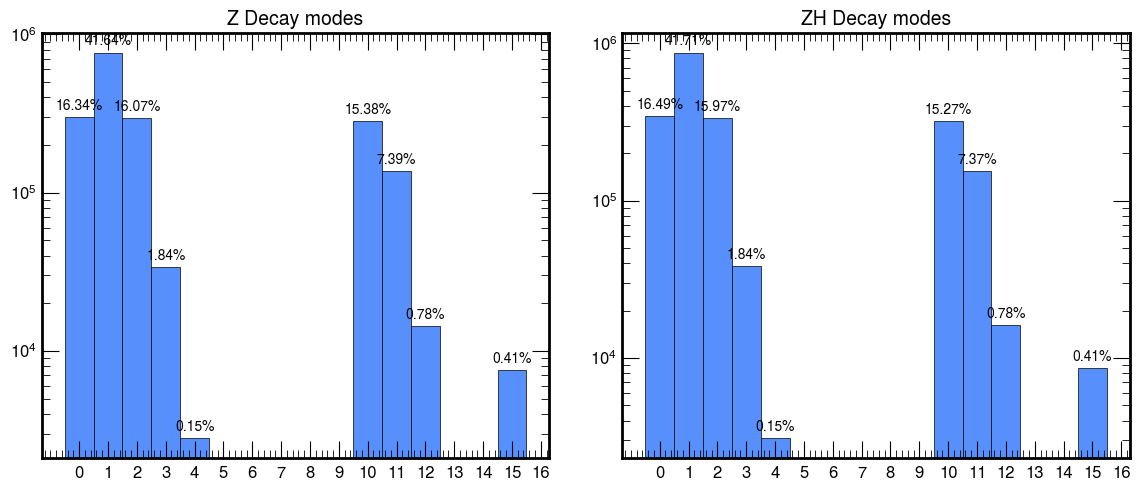

In [ ]:
def annotate_bars(ax, percentages, total_count):
    for bar in ax.patches:
        height = bar.get_height()
        decay_mode = int(bar.get_x() + bar.get_width() / 2)
        percentage = percentages.get(decay_mode, 0)
        if height > 0:
            ax.annotate(f'{percentage:.2f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5.5))
dms = np.arange(17)

# Z hist
axs[0].set_title("Z Decay modes", fontsize=14)
counts_z, _, bars_z = axs[0].hist(
    z_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[0].set_yscale('log')
axs[0].set_xticks(dms + 0.5, dms)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Annotate bars for z_data
annotate_bars(axs[0], z_data_percentages, total_count=len(z_data["gen_jet_tau_decaymode"]))

# ZH hist
axs[1].set_title("ZH Decay modes", fontsize=14)
counts_zh, _, bars_zh = axs[1].hist(
    zh_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[1].set_yscale('log')
axs[1].set_xticks(dms + 0.5, dms)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Annotate bars for zh_data
annotate_bars(axs[1], zh_data_percentages, total_count=len(zh_data["gen_jet_tau_decaymode"]))

plt.tight_layout()
plt.show()

## Decay mode remapping
Physically meaningful DMs are 0, 1, 2, 3, 4, 10, 11, 12, 15.

Since some DMs have a very small sample we classify them under similar ones like to DM3, 4 to DM2 and DM11, 12, 13, 14 to DM10.

In [ ]:
# Initial mapping
dm_mapping = {
        0: 'OneProng0PiZero',
        1: 'OneProng1PiZero',
        2: 'OneProng2PiZero',
        3: 'OneProng3PiZero',
        4: 'OneProngNPiZero',
        5: 'TwoProng0PiZero',
        6: 'TwoProng1PiZero',
        7: 'TwoProng2PiZero',
        8: 'TwoProng3PiZero',
        9: 'TwoProngNPiZero',
        10: 'ThreeProng0PiZero',
        11: 'ThreeProng1PiZero',
        12: 'ThreeProng2PiZero',
        13: 'ThreeProng3PiZero',
        14: 'ThreeProngNPiZero',
        15: 'RareDecayMode'
    }

In [ ]:
# Remapped dictionary with meaningful DMs
remap_d = {0: '$h^\pm$', # DM0
           1: '$h^\pm \pi^0$', # DM1
           2: '$h^\pm \geq 2\pi^0$', # DM2, DM3, DM4
           3: '$h^\pm h^\mp h^\pm$', # DM10
           4: '$h^\pm h^\mp h^\pm \geq 1\pi^0$', # DM11, DM12, DM13, DM14
           5: 'Other'} # DM15 and others 5-9 

# Hard coded remapping function
def remap(dm_array):
    dm_array = ak.to_numpy(dm_array)
    new_array = np.ones(len(dm_array)) * -1

    # Main decay modes 
    new_array[dm_array == 0] = 0 # DM0
    new_array[dm_array == 1] = 1 # DM1
    
    new_array[dm_array == 2] = 2 # DM2
    new_array[dm_array == 3] = 2
    new_array[dm_array == 4] = 2
    
    new_array[dm_array == 10] = 3 # DM3
    
    new_array[dm_array == 11] = 4 # DM4
    new_array[dm_array == 12] = 4
    new_array[dm_array == 13] = 4
    new_array[dm_array == 14] = 4
    
    new_array[dm_array == 15] = 5 # DM5
    
    new_array[dm_array == 5] = 5
    new_array[dm_array == 6] = 5
    new_array[dm_array == 7] = 5
    new_array[dm_array == 8] = 5
    new_array[dm_array == 9] = 5

    # The action of reassuring
    if np.any(new_array == -1):
        print("Array contains -1")

    # Decay mode and it's coutns
    dm, N = np.unique(new_array, return_counts = True)
    
    return new_array, dm, N

z_remap = remap(z_data['gen_jet_tau_decaymode'])
zh_remap = remap(zh_data['gen_jet_tau_decaymode'])

## Probability cross check with PDG

In [ ]:
class PDG_live:
    def __init__(self, value, error):
        self.value = value
        self.error = error
        
    def __repr__(self):
        return f"{self.value} ± {self.error}"

In [ ]:
def cross_product(values, initial_value):
    return [round(v / initial_value, 4) for v in values]

def calculate_ratios_and_uncertainties(values, initial_value, initial_std):
    """Calculate ratios and their uncertainties"""
    ratios = cross_product([v.value for v in values], initial_value)
    uncertainties = []
    
    for i, measurement in enumerate(values):
        A = measurement.value
        sigma_A = measurement.error
        R = ratios[i]
        
        # Calculate relative uncertainty for the ratio
        relative_uncertainty = (sigma_A / A)**2 + (initial_std / initial_value)**2
        sigma_R = R * (relative_uncertainty)**0.5
        uncertainties.append(round(sigma_R, 4))
    
    return ratios, uncertainties

In [ ]:
# Define initial value and its standard deviation
initial_perc = 64.79  # 100 - leptonic
initial_std = 0.06 # sqrt(0.04^2 + 0.04^2)

# Create the PDG values as instances of PDG_live
PDG_vals = {
    'Γ8': PDG_live(11.51, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.217&home=
    'Γ13': PDG_live(25.93, 0.09), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.171&home=
    'Γ17': PDG_live(10.81, 0.09), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.19&home=
    'Γ64': PDG_live(9.8, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.17&home=
    'Γ71': PDG_live(5.29, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.18&home=
    'Other': PDG_live(1.45, 0.15) # 1.45 = initial_perc - Γ8 - Γ13 - Γ17 - Γ64 - Γ71
}

# Convert dictionary values to list for processing
pdg_measurements = list(PDG_vals.values())

# Calculate ratios and uncertainties
PDG_ratios, PDG_uncertainties = calculate_ratios_and_uncertainties(pdg_measurements, initial_perc, initial_std)

# Z ratios
z_ratios = cross_product(z_remap[-1], sum(z_remap[-1]))

# ZH ratios
zh_ratios = cross_product(zh_remap[-1], sum(zh_remap[-1]))

print('z_ratios', z_ratios)
print('zh_ratios', zh_ratios)
print('PDG_ratios', PDG_ratios)

z_ratios [0.1634, 0.4164, 0.1806, 0.1538, 0.0817, 0.0041]
zh_ratios [0.1649, 0.4171, 0.1796, 0.1527, 0.0815, 0.0041]
PDG_ratios [0.1777, 0.4002, 0.1668, 0.1513, 0.0816, 0.0224]


In [ ]:
# The action of reassuring
print(sum(PDG_ratios), sum(z_ratios), sum(zh_ratios))

0.9999999999999999 0.9999999999999999 0.9999000000000001


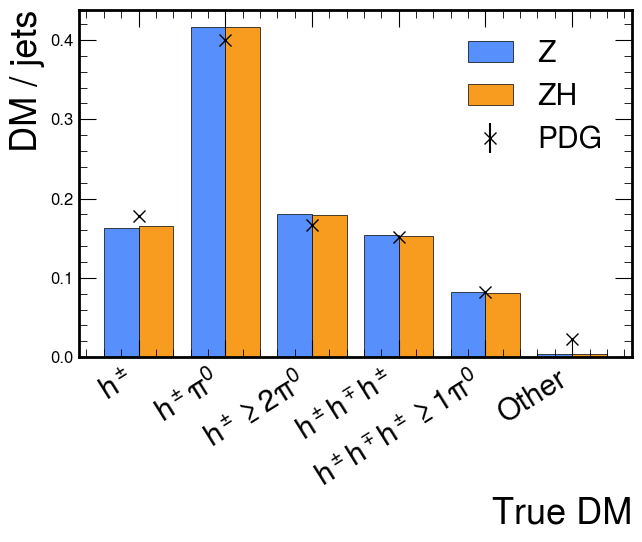

In [ ]:
# Number of decay modes
ind = np.arange(len(PDG_ratios))

# Width of the bars
width = 0.4

plt.figure(figsize=(7, 6))

# Plot the bars for Z and ZH
plt.bar(ind, z_ratios, width, label='Z', edgecolor='black', linewidth=0.5)
plt.bar(ind + width, zh_ratios, width, label='ZH', edgecolor='black', linewidth=0.5)

# Plot the PDG ratios with error bars
plt.errorbar(ind + width / 2,
             PDG_ratios,
             yerr=PDG_uncertainties,
             fmt='x',
             color='k',
             markersize=8,
             label='PDG')

# Set labels and title
plt.xlabel('True DM')
plt.ylabel('DM / jets')
#plt.title('Simulation vs PDG')

# Set x-axis ticks and labels
plt.xticks(ind + width / 2, [remap_d[i] for i in remap_d], rotation=32, ha='right')
plt.yticks(fontsize=12)

# Set y-axis to logarithmic scale
#plt.yscale('log')

plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('pdg_crosscheck.pdf')

plt.show()

## Z and ZH jet 2D shapes

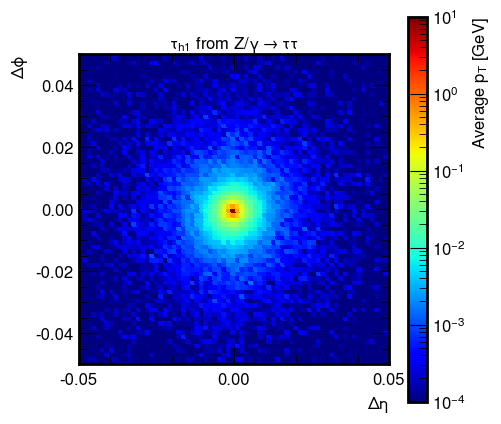

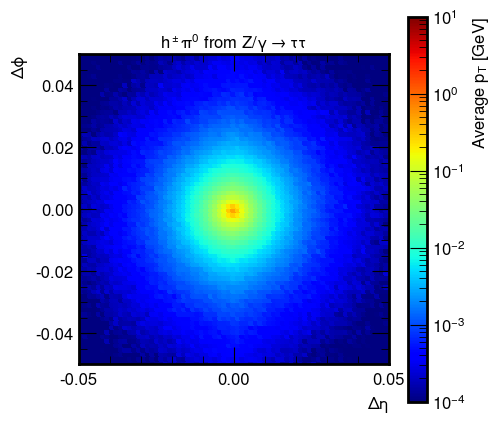

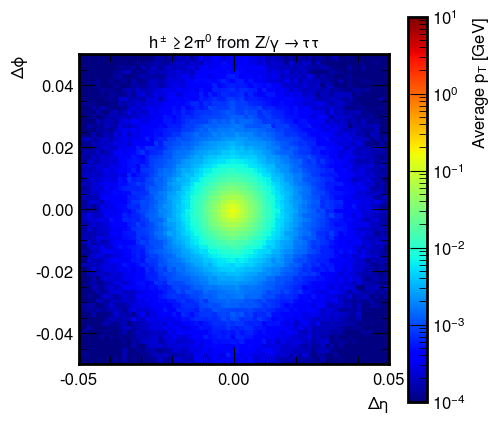

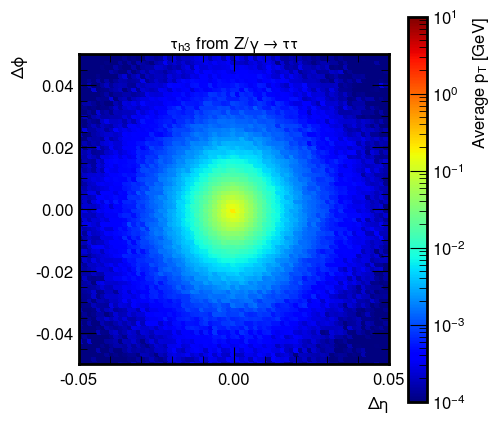

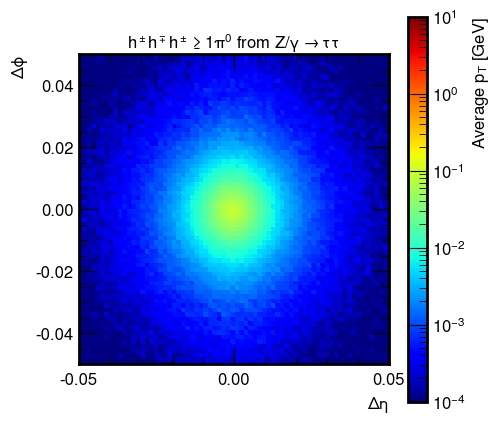

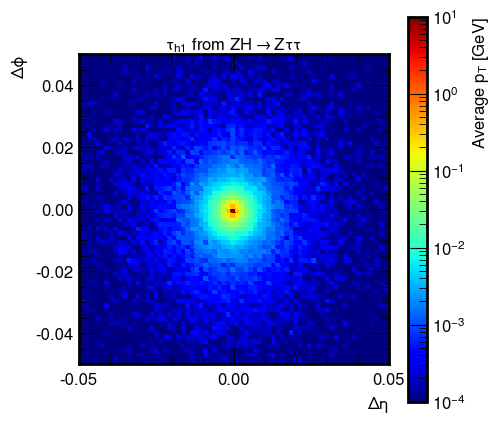

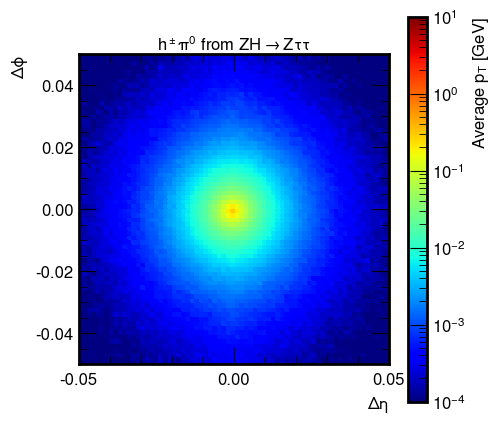

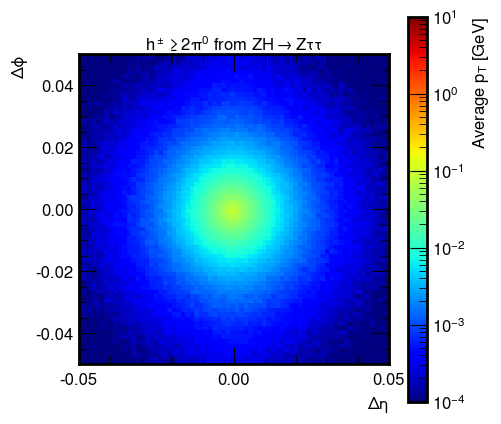

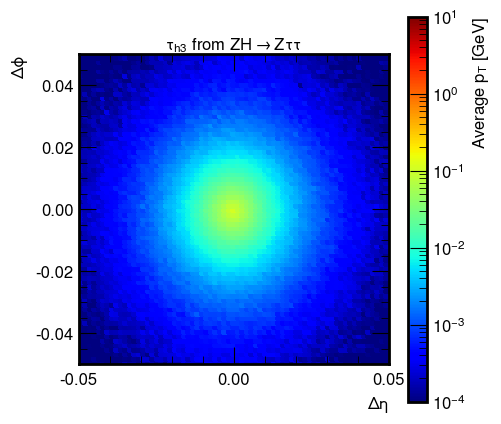

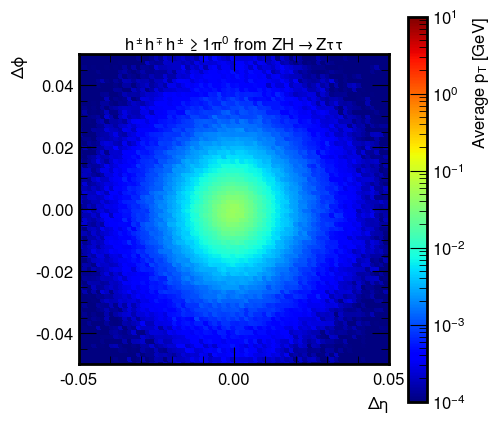

In [ ]:
def plot_2d_histogram(data, mask, title, save=False, filename=None,
                      xlabel=r"$\Delta \eta$", ylabel=r"$\Delta \phi$",
                      bins=np.linspace(-0.05, 0.05, 70), cmap=mpl.cm.jet):
    
    # Flatten arrays and apply the mask
    delta_eta_flat = ak.to_numpy(ak.flatten(data['delta_eta'][mask]))
    delta_phi_flat = ak.to_numpy(ak.flatten(data['delta_phi'][mask]))
    pt_flat = ak.to_numpy(ak.flatten(data['pt'][mask]))
    
    # Create a new figure
    fig = plt.figure(figsize=(5, 5))
    
    # Plot the 2D histogram of delta_eta and delta_phi weighted by pT, divided by the number of particles
    hist2d = plt.hist2d(delta_eta_flat,
                        delta_phi_flat,
                        bins=bins,
                        weights=pt_flat/len(pt_flat),
                        norm=mpl.colors.LogNorm(vmin=0.0001, vmax=10, clip=True), 
                        cmap=cmap,
                        edgecolor='face')
    plt.xlabel(xlabel, fontsize=12) 
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=12, pad=3, rotation='horizontal')
    
    # Colorbar
    cbar = plt.colorbar(hist2d[3])
    cbar.set_label('Average $p_T$ [GeV]', fontsize=12)
    
    # Set tick parameters for x, y, and colorbar axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    ax = plt.gca()
    ax.set_aspect('equal')
    fig.set_size_inches([5, 5],forward=True)
    
    # Save the figure if requested
    if save and filename:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

def plot_histograms_for_decay_modes(data, decay_modes_of_interest, remap_d, dataset_name, save=False):
    dataset_d = {
        "Z": r"$Z/\gamma \rightarrow \tau\tau$",
        "ZH": r"$ZH \rightarrow Z\tau\tau$"
    }
    new_remap = dict(remap_d)
    new_remap[0] = r'$\tau_{h1}$'
    new_remap[3] = r'$\tau_{h3}$'
    # Loop through each decay mode 
    for idx_decaymode in decay_modes_of_interest:
        mask = (data['decay_mode'] == idx_decaymode)
        title = f'{new_remap[idx_decaymode]} from {dataset_d[dataset_name]}'
        filename = None
        if save:
            filename = f'jet_2D_shapes_{dataset_name}_DM{idx_decaymode}.pdf'
        
        plot_2d_histogram(data, mask, title, save=save, filename=filename)

# Data dictionaries
Z_data = {
    'delta_eta': z_delta_eta,
    'delta_phi': z_delta_phi,
    'pt': z_reco_cand_p4s.pt,
    'decay_mode': z_remap[0]
}

ZH_data = {
    'delta_eta': zh_delta_eta,
    'delta_phi': zh_delta_phi,
    'pt': zh_reco_cand_p4s.pt,
    'decay_mode': zh_remap[0]
}

#decay_modes_of_interest = [0, 3]
decay_modes_of_interest = [0, 1, 2, 3, 4]

# Plot and save figures for Z data
plot_histograms_for_decay_modes(Z_data, decay_modes_of_interest, remap_d, 'Z', save=True)

# Plot and save figures for ZH data
plot_histograms_for_decay_modes(ZH_data, decay_modes_of_interest, remap_d, 'ZH', save=True)

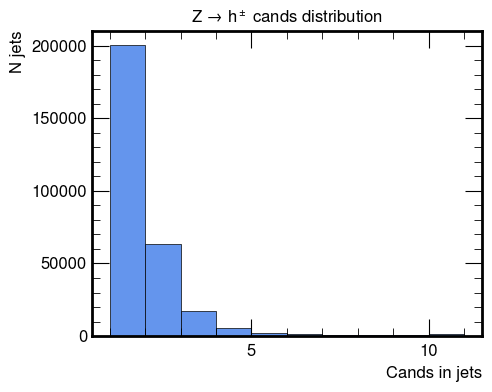

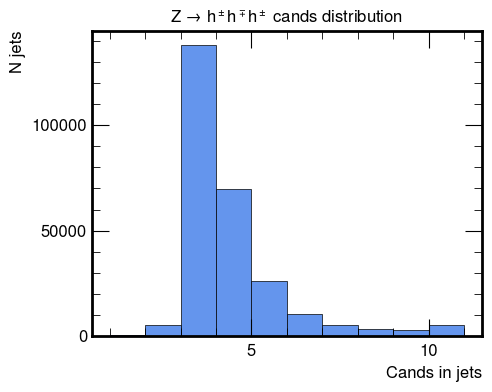

KeyboardInterrupt: 

In [ ]:
# Loop through each decay mode

def plot_cands_distribution(data, decay_modes_of_interest, dataset_name):
    for idx_decaymode in decay_modes_of_interest:
        mask = (data['decay_mode'] == idx_decaymode)
        cands = data["reco_cand_p4s"][mask]
        jets = data["reco_jet_p4s"][mask]
        
        # List to store particle counts per jet for the current decay mode
        cands_counts = [len(c) for c in cands]
        
        # Create a new figure for each decay mode
        plt.figure(figsize=(5.5, 4.5))
        
        # Plot the histogram of particle counts per jet
        plt.hist(cands_counts, color='cornflowerblue', bins=np.linspace(1, 11, 11),
                 edgecolor='black', linewidth=0.5)
        plt.xlabel("Cands in jets", fontsize=12) 
        plt.ylabel("N jets", fontsize=12)
        plt.title(f"{dataset_name} → {remap_d[idx_decaymode]} cands distribution", fontsize=12)
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
       
        plt.tight_layout()
        plt.show()

# Assuming z_data and zh_data are dictionaries containing necessary arrays
Z_data1 = {
    'reco_cand_p4s': z_reco_cand_p4s,
    'reco_jet_p4s': z_reco_jet_p4s,
    'decay_mode': z_remap[0]
}

ZH_data1 = {
    'reco_cand_p4s': zh_reco_cand_p4s,
    'reco_jet_p4s': zh_reco_jet_p4s,
    'decay_mode': zh_remap[0]
}

decay_modes_of_interest = [0, 3]

# Plot Z data
plot_cands_distribution(Z_data1, decay_modes_of_interest, 'Z')

# Plot ZH data
plot_cands_distribution(ZH_data1, decay_modes_of_interest, 'ZH')

## Tracking variables

In [ ]:
def plot_all_samples(variable, bins):
    plt.figure(figsize=(7,5.5))
    
    # Z plot
    mplhep.histplot(to_bh(ak.flatten(z_data[variable]), bins=bins), 
                    histtype="step", 
                    lw=1, 
                    flow="sum", 
                    label="Z", 
                    density=True)
    # ZH plot
    mplhep.histplot(to_bh(ak.flatten(zh_data[variable]), bins=bins),
                    histtype="step",
                    lw=1, flow="sum",
                    label="ZH",
                    density=True)
    # qq plot
    mplhep.histplot(to_bh(ak.flatten(qq_data[variable]), bins=bins),
                    histtype="step",
                    lw=1,
                    flow="sum",
                    label="qq",
                    density=True)
    
    plt.legend(loc="best")
    plt.yscale("log")
    
    plt.ylabel("Fraction of reco particles [a.u.]")

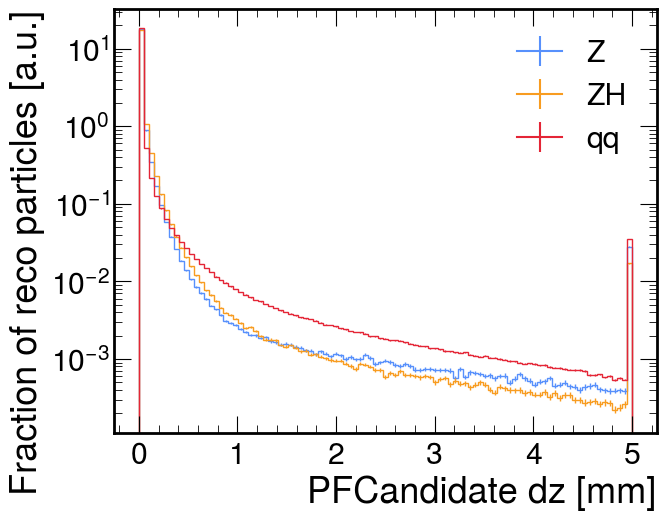

In [ ]:
plot_all_samples("reco_cand_dz", np.linspace(0,5,100))
plt.xlabel("PFCandidate dz [mm]");

Text(1, 0, 'PFCandidate dz error [mm]')

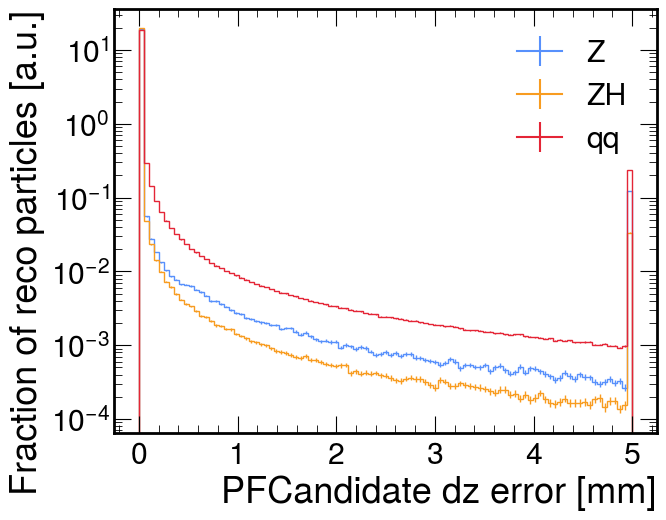

In [ ]:
plot_all_samples("reco_cand_dz_err", np.linspace(0,5,100))
plt.xlabel("PFCandidate dz error [mm]")

Text(1, 0, 'PFCandidate dxy [mm]')

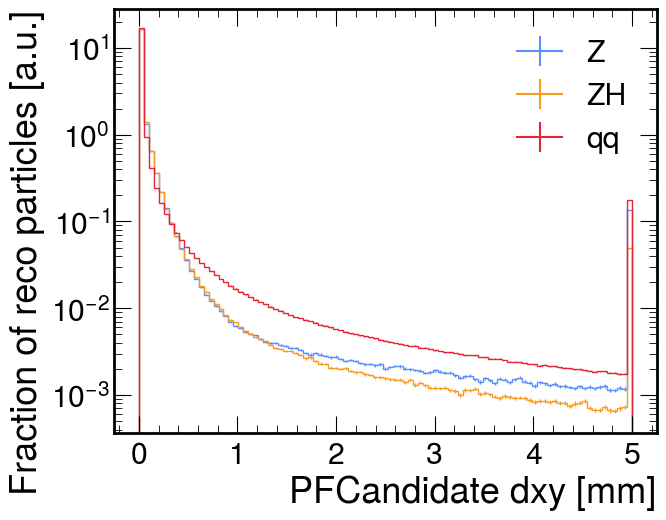

In [ ]:
plot_all_samples("reco_cand_dxy", np.linspace(0,5,100))
plt.xlabel("PFCandidate dxy [mm]")

Text(1, 0, 'PFCandidate d3 error [mm]')

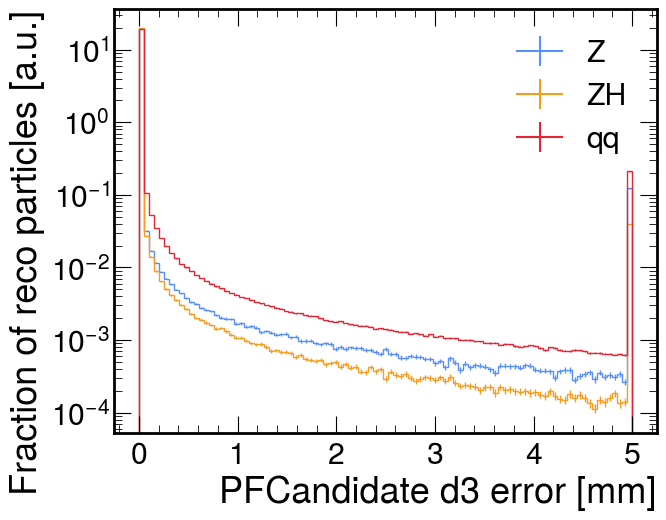

In [ ]:
plot_all_samples("reco_cand_dxy_err", np.linspace(0,5,100))
plt.xlabel("PFCandidate d3 error [mm]")

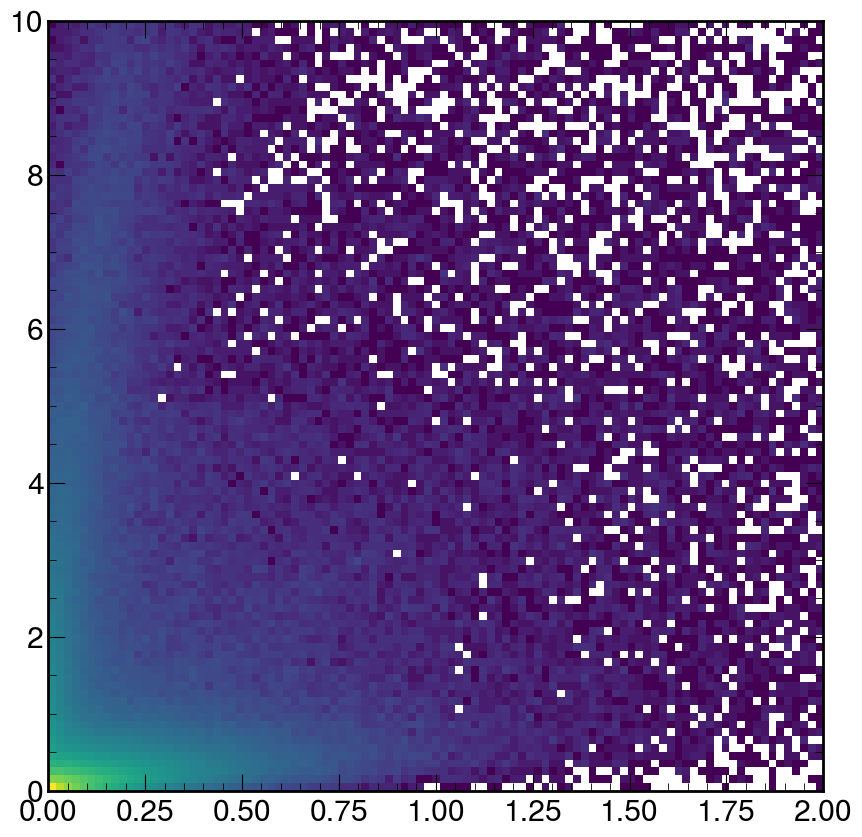

In [ ]:
plt.hist2d(
    ak.to_numpy(ak.flatten(z_data["reco_cand_dz"])),
    ak.to_numpy(ak.flatten(z_data["reco_cand_dxy"])),
    bins=(np.linspace(0,2,100), np.linspace(0,10,100)), norm=mpl.colors.LogNorm()
);

In [ ]:
qq_data.fields

['reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'reco_cand_dxy',
 'reco_cand_dz',
 'reco_cand_dxy_err',
 'reco_cand_dz_err',
 'gen_jet_p4s',
 'gen_jet_tau_decaymode',
 'gen_jet_tau_p4s']